In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from flox.xarray import xarray_reduce
import gsw

In [2]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))

In [3]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 2550896)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
    TIME               (N_PROF) datetime64[ns] 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LATITUDE           (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LONGITUDE          (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
  * N_PROF             (N_PROF) int64 20MB 0 1 2 3 ... 2550893 2550894 2550895
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DATA_MODE          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DIRECTION          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SA                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [4]:
lon_bins = np.arange(-180,181,1)
lat_bins = np.arange(-90,91,1)

In [5]:
def get_ds_clim(ds, lon_bins, lat_bins):
    """
    Compute a monthly climatology from an xarray dataset by binning profiles 
    spatially and grouping them by year-month.

    Parameters:
    ds (xr.Dataset): Input dataset containing N_PROF dimension.
    lon_bins (array-like): Longitude bin edges.
    lat_bins (array-like): Latitude bin edges.

    Returns:
    xr.Dataset: Binned monthly climatology dataset.
    """
    
    # Extract year-month from TIME
    ds = ds.assign_coords(
        year_month=("N_PROF", pd.to_datetime(ds.TIME.values).strftime("%Y-%m"))
    )

    # Apply binning function
    ds_binned = xarray_reduce(
        ds,
        "LONGITUDE",
        "LATITUDE",
        func="mean",
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins),
        ),
        fill_value=np.nan,
        skipna=True,
    )

    # Compute bin midpoints
    lon_l = np.arange(lon_bins[0], lon_bins[-1], 1)
    lon_r = np.arange(lon_bins[1], lon_bins[-1] + 1, 1)
    lon_c = (lon_l + lon_r) / 2

    lat_l = np.arange(lat_bins[0], lat_bins[-1], 1)
    lat_r = np.arange(lat_bins[1], lat_bins[-1] + 1, 1)
    lat_c = (lat_l + lat_r) / 2

    # Assign new coordinates
    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
        "year_month": ("N_PROF", ds.year_month.data),
    })

    # Swap dimensions for clarity
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])

    # Rename depth dimension
    if isinstance(ds_binned, xr.Dataset):
        ds_binned = ds_binned.rename_dims({"PRES_INTERPOLATED": "z_c"}).rename_vars({"PRES_INTERPOLATED": "z_c"})
    elif isinstance(ds_binned, xr.DataArray):
        ds_binned = ds_binned.rename({"PRES_INTERPOLATED": "z_c"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    # Group by year-month for climatology
    ds_climatology = ds_binned.groupby("year_month").mean(dim="N_PROF", skipna=True)

    return ds_climatology

In [6]:
ds_clim = get_ds_clim(ds, lon_bins, lat_bins)

In [7]:
ds_clim

<xarray.Dataset> Size: 1TB
Dimensions:          (z_c: 1001, lat_c: 180, lon_c: 360, year_month: 323)
Coordinates:
  * z_c              (z_c) int64 8kB 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
  * lat_c            (lat_c) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
    lat_l            (lat_c) int64 1kB -90 -89 -88 -87 -86 ... 85 86 87 88 89
    lat_r            (lat_c) int64 1kB -89 -88 -87 -86 -85 ... 86 87 88 89 90
  * lon_c            (lon_c) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
    lon_l            (lon_c) int64 3kB -180 -179 -178 -177 ... 176 177 178 179
    lon_r            (lon_c) int64 3kB -179 -178 -177 -176 ... 177 178 179 180
  * year_month       (year_month) object 3kB '1998-05' '1998-06' ... '2025-03'
Data variables:
    CT               (year_month, z_c, lon_c, lat_c) float64 168GB dask.array<chunksize=(323, 1001, 360, 180), meta=np.ndarray>
    CYCLE_NUMBER     (year_month, lon_c, lat_c) float64 167MB dask.array<chunksize=(323, 360, 180), meta=np.ndarray>
    DATA_MODE        (year_month, lon_c, lat_c) float64 167MB dask.array<chunksize=(323, 360, 180), meta=np.ndarray>
    DIRECTION        (year_month, lon_c, lat_c) float64 167MB dask.array<chunksize=(323, 360, 180), meta=np.ndarray>
    PLATFORM_NUMBER  (year_month, lon_c, lat_c) float64 167MB dask.array<chunksize=(323, 360, 180), meta=np.ndarray>
    PRES             (year_month, z_c, lon_c, lat_c) float32 84GB dask.array<chunksize=(323, 1001, 360, 180), meta=np.ndarray>
    PSAL             (year_month, z_c, lon_c, lat_c) float32 84GB dask.array<chunksize=(323, 1001, 360, 180), meta=np.ndarray>
    SA               (year_month, z_c, lon_c, lat_c) float64 168GB dask.array<chunksize=(323, 1001, 360, 180), meta=np.ndarray>
    SIG0             (year_month, z_c, lon_c, lat_c) float64 168GB dask.array<chunksize=(323, 1001, 360, 180), meta=np.ndarray>
    TEMP             (year_month, z_c, lon_c, lat_c) float32 84GB dask.array<chunksize=(323, 1001, 360, 180), meta=np.ndarray>
    sample_rate      (year_month, z_c, lon_c, lat_c) float32 84GB dask.array<chunksize=(323, 1001, 360, 180), meta=np.ndarray>
    SPICE            (year_month, z_c, lon_c, lat_c) float64 168GB dask.array<chunksize=(323, 1001, 360, 180), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [8]:
ds_clim["year_month"] = pd.to_datetime(ds_clim["year_month"])

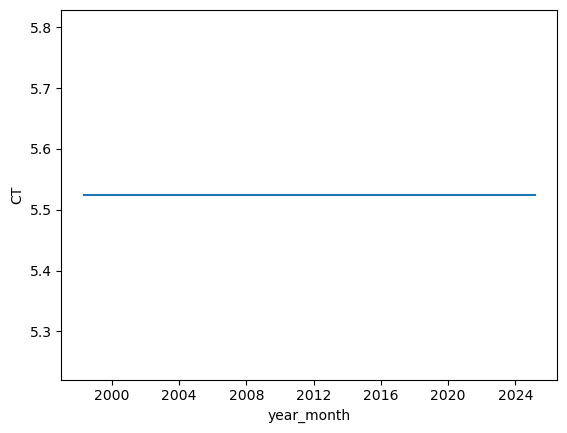

In [9]:
ds_clim.CT.mean(['z_c', 'lat_c', 'lon_c']).plot()

In [10]:
month = '2018-12'
depth = 1000
plot = ds_clim.sel(year_month=month).sel(z_c=depth, method='nearest')

In [11]:
SP = gsw.SP_from_SA(ds_clim.SA, ds_clim.PRES, ds_clim.lon_c, ds_clim.lat_c)
plot_SP = SP.sel(year_month=month).sel(z_c=depth, method='nearest')

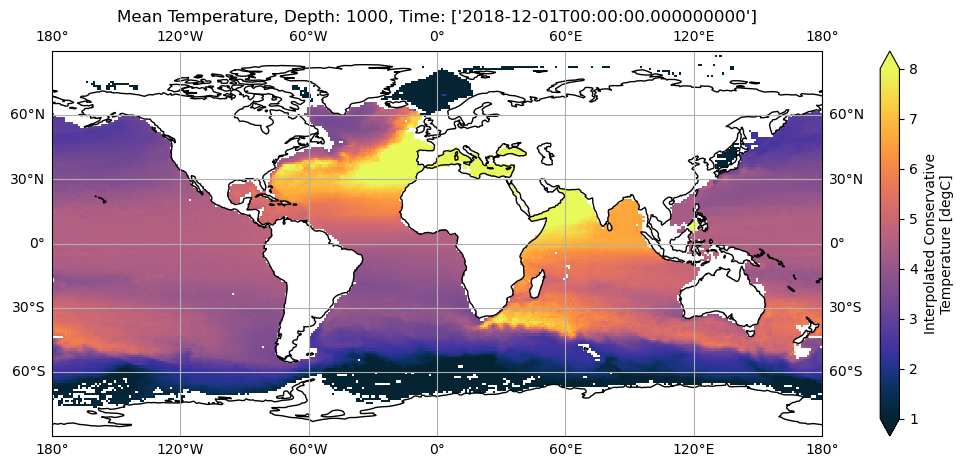

In [12]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
plot.CT.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=1, vmax=8)
ax.set_title('Mean Temperature, Depth: {}, Time: {}'.format(plot.z_c.values, plot.year_month.values));

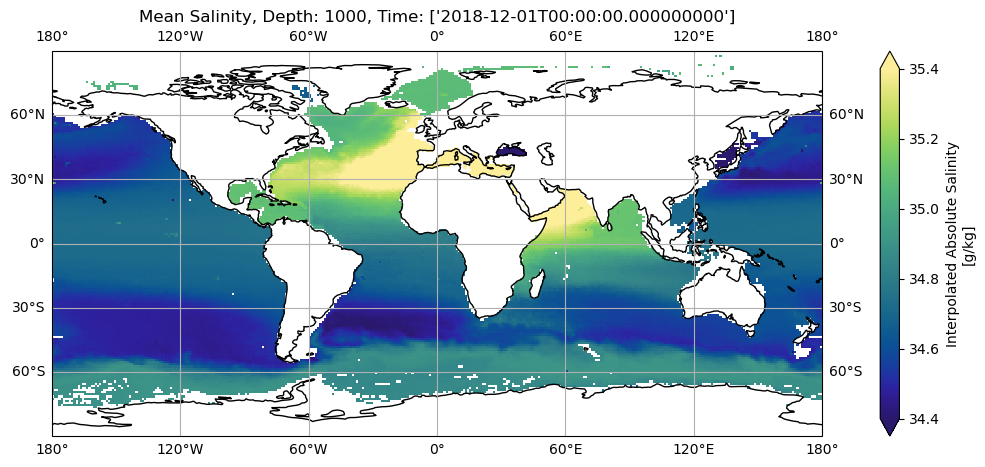

In [13]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
plot.SA.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.haline, vmin=34.4, vmax=35.4)
ax.set_title('Mean Salinity, Depth: {}, Time: {}'.format(plot.z_c.values, plot.year_month.values));

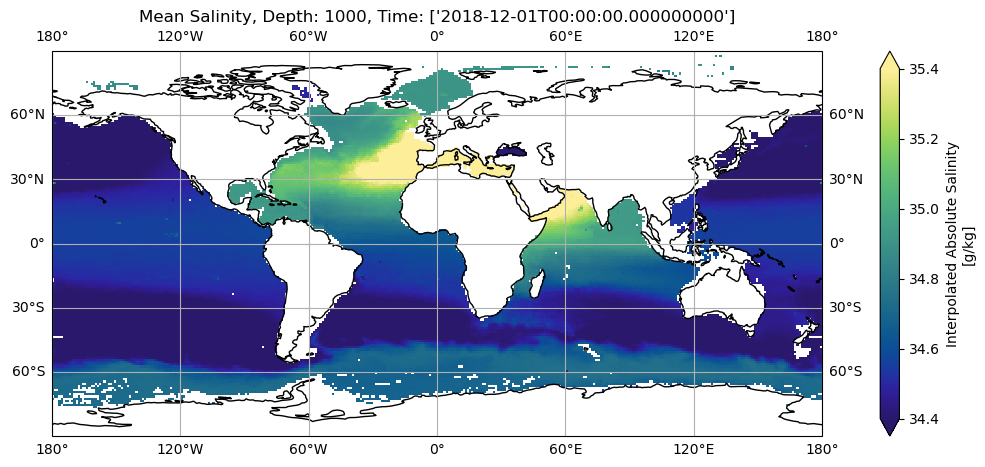

In [14]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
plot_SP.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.haline, vmin=34.4, vmax=35.4)
ax.set_title('Mean Salinity, Depth: {}, Time: {}'.format(plot.z_c.values, plot.year_month.values));

Need to take a closer look at the function I think. The temperature dataset looks near perfect compared to RG, however the salinity looks significantly different, even though I've updated the extends of the colorbars to be the same.

Salinity scales are different! So they will be a little off from each other. Honestly I'm suprise temp looks so perfect

In [15]:
dCT_dx = ds_clim.CT.differentiate('lon_c').mean('year_month').compute()
dCT_dy = ds_clim.CT.differentiate('lat_c').mean('year_month').compute()

In [16]:
dSA_dx = ds_clim.SA.differentiate('lon_c').mean('year_month').compute()
dSA_dy = ds_clim.SA.differentiate('lat_c').mean('year_month').compute()

In [17]:
dSP_dx = ds_clim.SPICE.differentiate('lon_c').mean('year_month').compute()
dSP_dy = ds_clim.SPICE.differentiate('lat_c').mean('year_month').compute()

In [18]:
depth = 1000

In [19]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

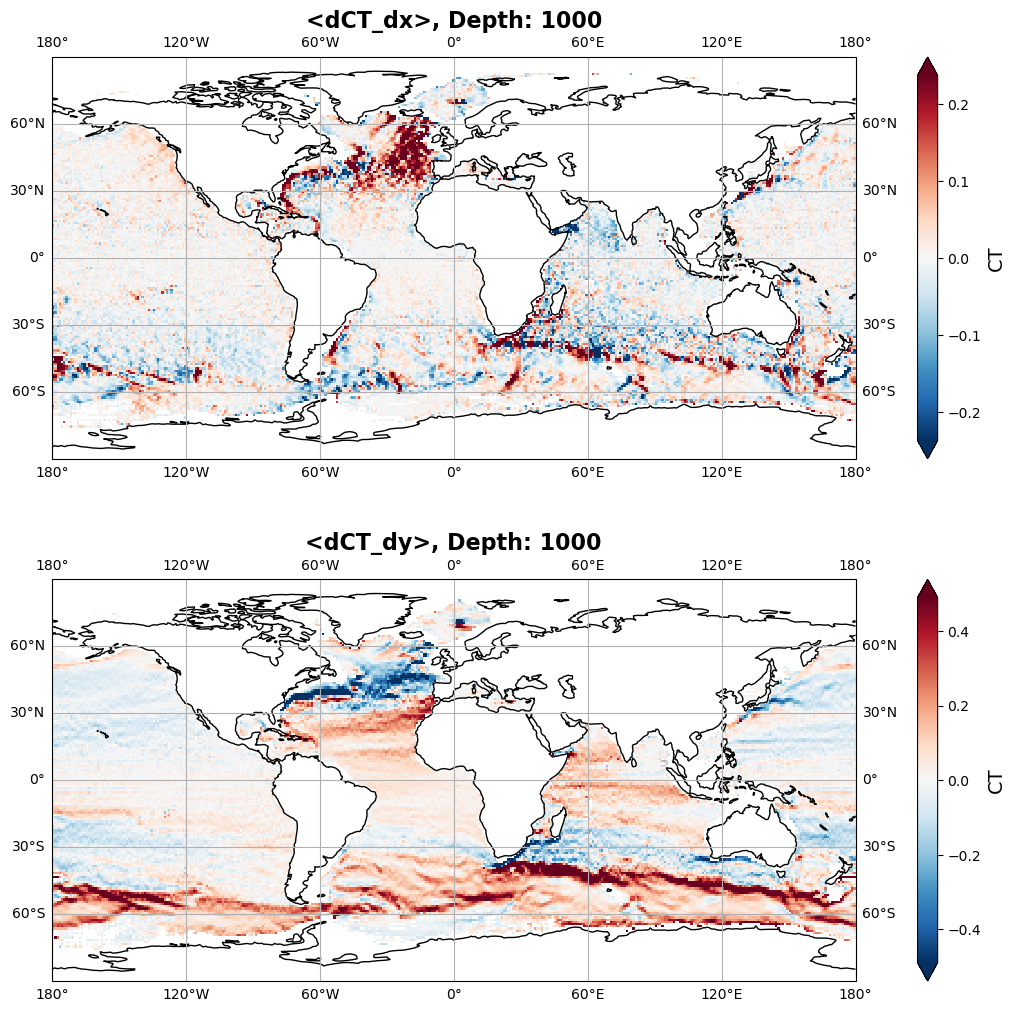

In [20]:
fig=plt.figure(figsize=(16,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
dCT_dx.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), robust=True)
ax1.set_title('<dCT_dx>, Depth: {}'.format(plot.z_c.values))

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
dCT_dy.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), robust=True)
ax2.set_title('<dCT_dy>, Depth: {}'.format(plot.z_c.values))

plt.subplots_adjust(hspace=0.3)

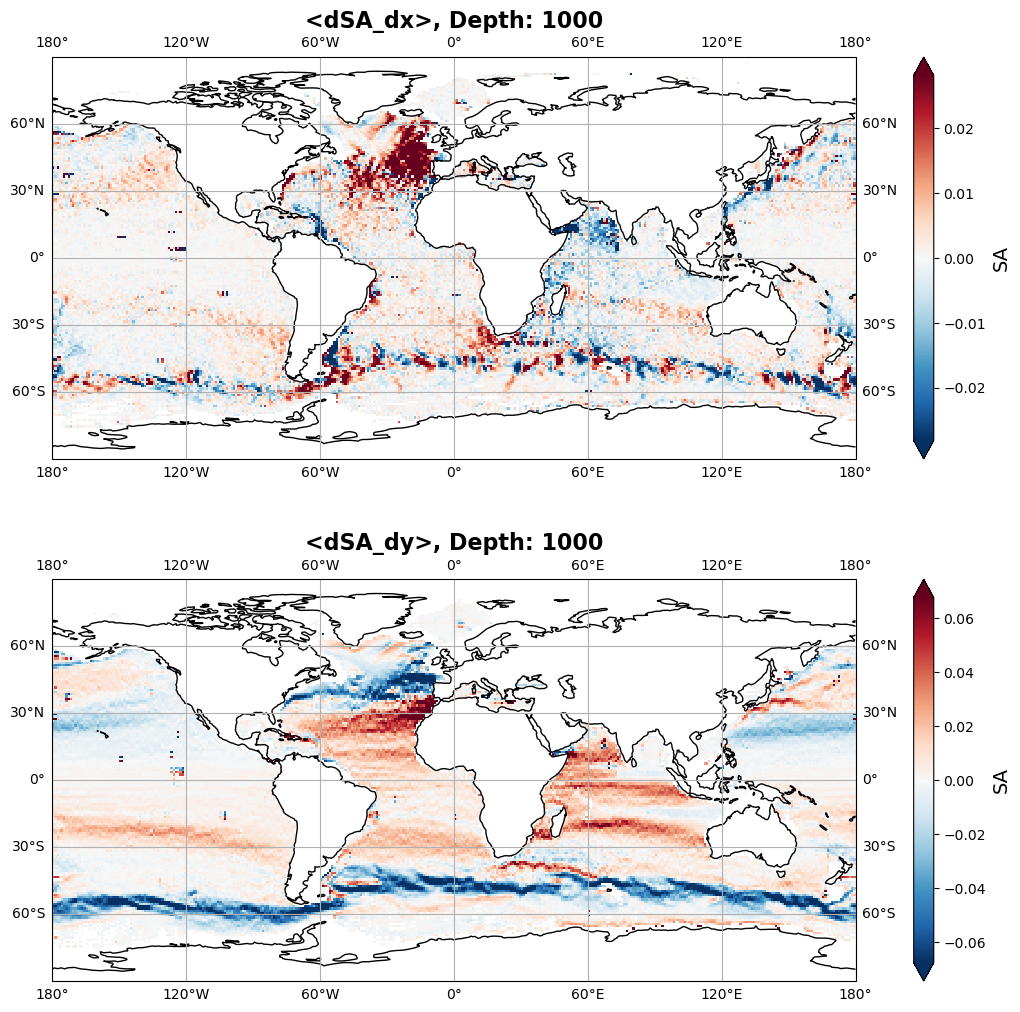

In [21]:
fig=plt.figure(figsize=(15,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
dSA_dx.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), robust=True)
ax1.set_title('<dSA_dx>, Depth: {}'.format(plot.z_c.values))

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
dSA_dy.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), robust=True)
ax2.set_title('<dSA_dy>, Depth: {}'.format(plot.z_c.values))

plt.subplots_adjust(hspace=0.3)

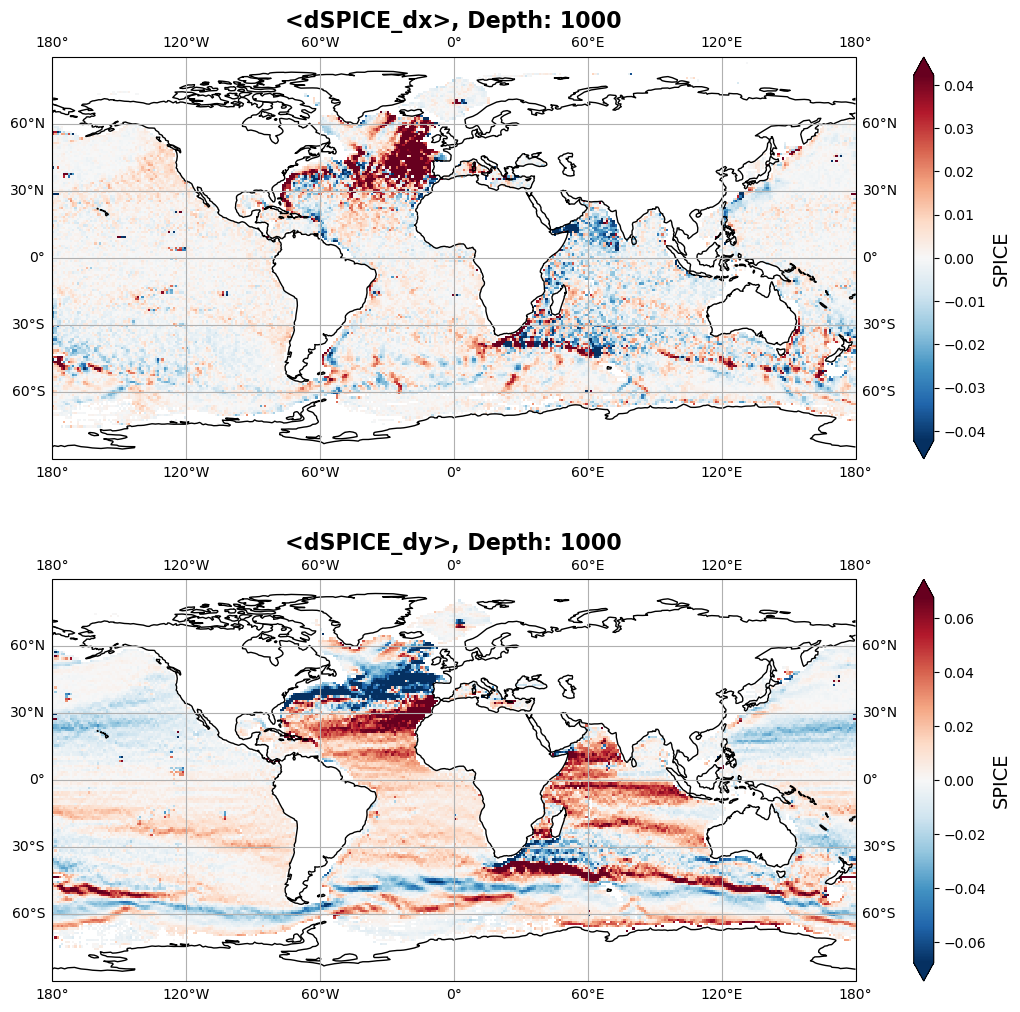

In [22]:
fig=plt.figure(figsize=(15,12))
ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_global()
dSP_dx.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax1,transform=ccrs.PlateCarree(), robust=True)
ax1.set_title('<dSPICE_dx>, Depth: {}'.format(plot.z_c.values, plot.year_month.values))

ax2 = plt.subplot(212, projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=True)
ax2.set_global()
dSP_dy.sel(z_c=depth).plot(x='lon_c',y='lat_c',ax=ax2,transform=ccrs.PlateCarree(), robust=True)
ax2.set_title('<dSPICE_dy>, Depth: {}'.format(plot.z_c.values, plot.year_month.values))

plt.subplots_adjust(hspace=0.3)